# Live Loss Plot for PyToune

[PyToune](https://pytoune.org/) is a Keras-like framework for [PyTorch](https://pytorch.org/) and handles much of the boilerplating code needed to train neural networks.

You can use PyToune to:
- Train models easily.
- Use callbacks to save your best model, perform early stopping and much more.

See more at [pytoune.org](https://pytoune.org/). In this notebook, we show how to use Live Loss Plot with PyToune.

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.init import xavier_normal_

from torchvision import transforms
from torchvision.datasets.mnist import MNIST

from pkg_resources import parse_version
import pytoune
assert parse_version(pytoune.__version__) >= parse_version('0.4'), "Please update your PyToune version."

from pytoune.framework import Model
from pytoune.layers import Flatten

from livelossplot.pytoune import PlotLossesCallback

In [2]:
# data loading
train_dataset = MNIST('./tmp/mnist/', 
                      train=True, 
                      download=True, 
                      transform=transforms.ToTensor())
test_dataset = MNIST('./tmp/mnist/', 
                     train=False, 
                     download=True, 
                     transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [3]:
# initialization function
def init_module(module):
    for m in module.modules():
        if isinstance(m, nn.Linear):
            xavier_normal_(m.weight.data, 1)
            m.bias.data.zero_()

In [4]:
# defining model
torch.manual_seed(42)
module = nn.Sequential(
    Flatten(),
    nn.Linear(28*28, 10),
)
init_module(module)

optimizer = optim.Adam(module.parameters(), lr=1e-3)
model = Model(module, 
              optimizer, 
              nn.CrossEntropyLoss(), 
              metrics=['accuracy'])

if torch.cuda.is_available():
    model.cuda(1)

In [5]:
# setting up the livelossplot callback
metric2title = {
    'loss': 'Cross-Entropy Loss', 
    'acc':'Accuracy'
}
plot_losses = PlotLossesCallback(metric2title=metric2title)

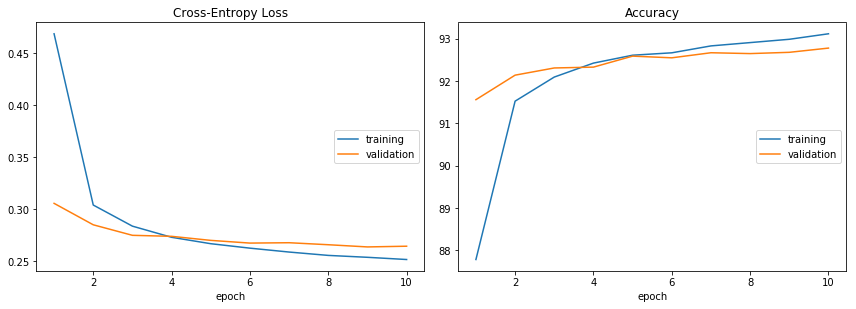

Cross-Entropy Loss:
training   (min:    0.251, max:    0.468, cur:    0.251)
validation (min:    0.264, max:    0.305, cur:    0.264)

Accuracy:
training   (min:   87.780, max:   93.118, cur:   93.118)
validation (min:   91.560, max:   92.780, cur:   92.780)


In [6]:
# fitting the model
history = model.fit_generator(train_loader, test_loader,
                              epochs=10,
                              callbacks=[plot_losses],
                              verbose=False)